In [98]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from seaborn import pointplot
from keras.models import model_from_yaml
from librosa.display import specshow


sys.path.append('/home/ci411/pcen-t-varying/')

import pcen_t.eval
from pcen_t.utils import *
from pcen_t.models import SqueezeLayer


URBANSED_CLASSES = ['air_conditioner',
                    'car_horn',
                    'children_playing',
                    'dog_bark',
                    'drilling',
                    'engine_idling',
                    'gun_shot',
                    'jackhammer',
                    'siren',
                    'street_music']

In [99]:
slices_single = [str(i) for i in range(10)]
slices_multiple = [''.join(str(j) for j in np.arange(i+1)) for i in range(10)]
slices_midout = [''.join(str(j) for j in np.arange(n, 10-n)) for n in range(4,-1,-1)]
slices_midout.insert(0, '5')

real_reverb_set = ['bedroom','tunnel','alley']
sim_reverb_set = ['short','medium','long']

In [100]:
sample_df = pd.read_csv('sampled_results.csv', index_col=0)
sample_df['slices'] = sample_df['version'].map(lambda x : str(x.split('_')[1]))
sample_df['modelset'] = sample_df['version'].map(lambda x : str(x.split('_')[2]))

/home/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [101]:
sample_df['num_slices'] = sample_df['slices'].apply(lambda x : len(str(x)))

mel_rows = sample_df['slices'] == 'mel'
sample_df.loc[sample_df['slices'] == 'mel','num_slices'] = 0
sample_df

,version,training_set,slices,eval_dataset,model,class/metric,value,metric,class,modelset,num_slices
0,dry_5_model711,dry,5,wet,cnn_l3_strong,overall_p,0.359660,precision,overall,model711,1
1,dry_5_model711,dry,5,bedroom,cnn_l3_strong,overall_p,0.478077,precision,overall,model711,1
2,dry_5_model711,dry,5,long,cnn_l3_strong,overall_p,0.168240,precision,overall,model711,1
3,dry_5_model711,dry,5,short,cnn_l3_strong,overall_p,0.236131,precision,overall,model711,1
4,dry_5_model711,dry,5,tunnel,cnn_l3_strong,overall_p,0.172904,precision,overall,model711,1
...,...,...,...,...,...,...,...,...,...,...,...
3379195,simreverb_01234_model711,simreverb,01234,tunnel,cnn_l3_strong,street_music_e,0.992806,error_rate,street_music,model711,5
3379196,simreverb_01234_model711,simreverb,01234,medium,cnn_l3_strong,street_music_e,1.021127,error_rate,street_music,model711,5
3379197,simreverb_01234_model711,simreverb,01234,short,cnn_l3_strong,street_music_e,1.011364,error_rate,street_music,model711,5
3379198,simreverb_01234_model711,simreverb,01234,alley,cnn_l3_strong,street_music_e,0.893939,error_rate,street_music,model711,5


In [102]:
groupby_model = sample_df.groupby('version')
percent_missing = []
for name, group in groupby_model:
    n_nan = len(group[np.isnan(group['value'])])
    percent_missing.append((name,n_nan/len(group)))

error_df = pd.DataFrame(percent_missing, columns=['version', '% NaN'])

In [103]:
error_df.sort_values('% NaN')

,version,% NaN
0,dry_0123456789_model711,0.000000
22,dry_9_model711,0.000000
20,dry_7_model711,0.000000
15,dry_3_model711,0.000000
84,wet_234567_model711,0.000000
...,...,...
57,simreverb_0_model711,0.012841
18,dry_5_model711,0.013125
33,realreverb_0_model711,0.014886
47,realreverb_mel_model711,0.020398


In [104]:
#DROP NANs
sample_df = sample_df.dropna(subset=['value'])

In [105]:
sample_df['slices'].unique()

array(['5', '1', '7', '12345678', '0123456789', '0', '2', '4', '3456',
       '234567', '6', '01', '8', '01234567', '012345678', '012345', '3',
       '012', '9', '0123456', '0123', '45', 'mel', '01234'], dtype=object)

<ipython-input-106-9175d659b572>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 0, '$\\log_2(T)$')

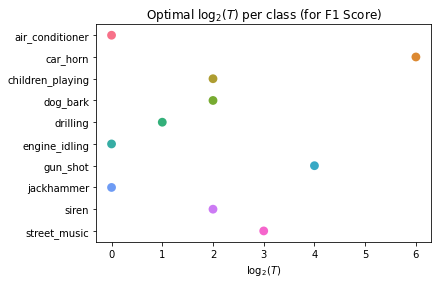

In [106]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_classgroup = f1_single_df.groupby('class')
best_single_slice = {}
for key, item in f1_classgroup:
    mean_series = f1_classgroup.get_group(key).groupby('slices').mean()
    max_slice = mean_series['value'].argmax()
    best_single_slice[key] = max_slice

classes = ['air_conditioner', 'car_horn', 'children_playing',\
           'dog_bark', 'drilling', 'engine_idling', 'gun_shot',\
           'jackhammer', 'siren', 'street_music']

best_slices = [best_single_slice[c] for c in classes]
sns.pointplot(x=best_slices, y=classes, join=False, palette='husl')
plt.title(r"Optimal $\log_2(T)$ per class (for F1 Score)")
plt.xlabel(r"$\log_2(T)$")

<ipython-input-107-6e755eca3d10>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (dry)')

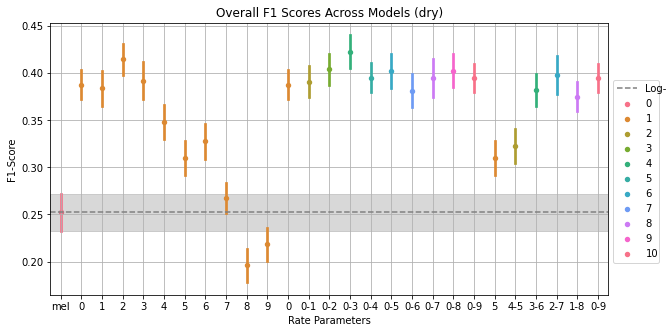

In [107]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = ['mel'] + slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1 or slices=='mel':
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (dry)')

<ipython-input-108-e52430c1a13f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (w/reverb)')

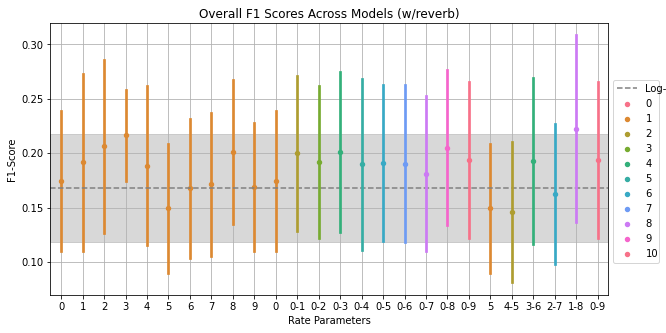

In [108]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1:
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (w/reverb)')

<ipython-input-109-cf5801fb2ae6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_dry_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-109-cf5801fb2ae6>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_wet_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (both)')

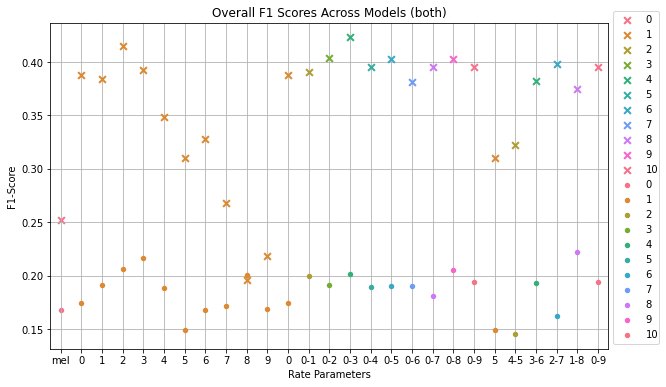

In [109]:
f1_dry_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['class']=='overall']

f1_wet_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['class']=='overall']

slices_all = ['mel'] + slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1 or slices=='mel':
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,6))

ax = sns.pointplot(x="slices", y="value", data=f1_dry_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci=None, join=False, markers='x')
sns.pointplot(x="slices", y="value", ax=ax, data=f1_wet_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci=None, join=False, markers='.')

ax.legend(bbox_to_anchor=(1,0, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (both)')

<ipython-input-110-37c64443674c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-110-37c64443674c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\


slices
0123456789    0.193924
Name: value, dtype: float64
0.19392379671490304
0123456789
0.0718580824814118


<ipython-input-110-37c64443674c>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-110-37c64443674c>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/home/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


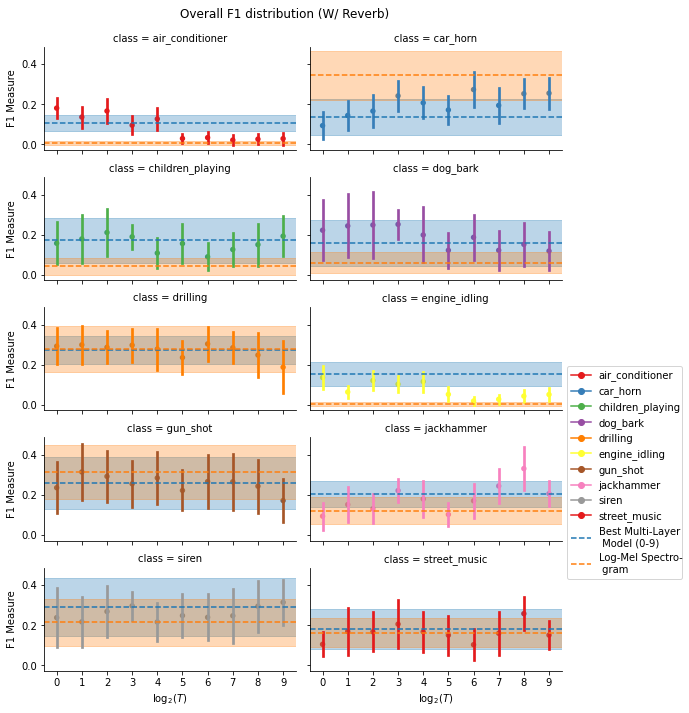

In [110]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]
print(means)
print(max_multi_val)
print(max_multi_slice)
print(max_multi_std)



#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, hue='class', palette='Set1', legend_out=True)

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C0', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C0', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C1', linestyle='--')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C1', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        

#add title   
plt.subplots_adjust(top=0.925)
#g.set(ylim=(0,.85))
g.fig.suptitle('Overall F1 distribution (W/ Reverb)')

#customize legend
legend_elements = [Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C0', linestyle='--', label="Best Multi-Layer\n Model ({}-{})".format(min(max_multi_slice), max(max_multi_slice))))
legend_elements.append(Line2D([0], [0], color='C1', linestyle='--', label="Log-Mel Spectro-\n gram"))



plt.legend(handles=legend_elements, bbox_to_anchor=(1,1,.5,2), mode='expand', loc='upper left')

In [111]:
f1_overall_df.groupby('slices')['value'].mean()

slices
0123456789    0.193924
Name: value, dtype: float64

<ipython-input-112-3e4987ea68b3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


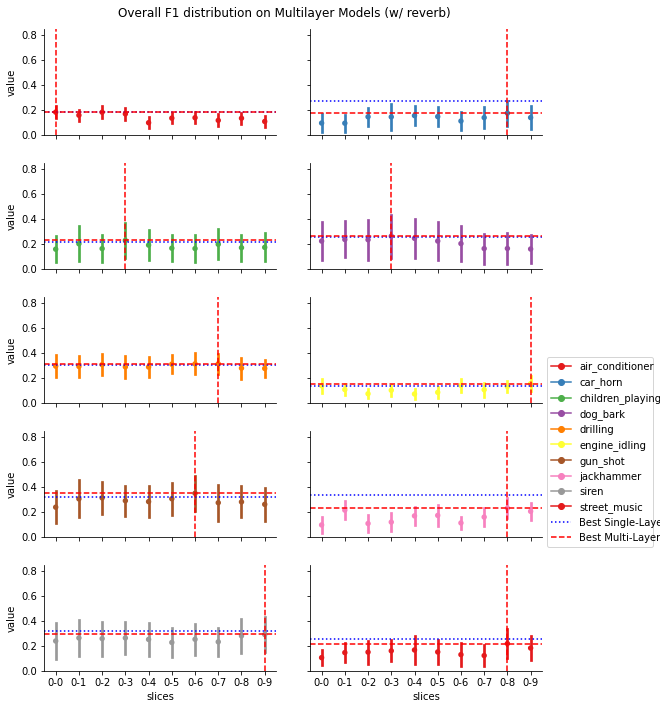

In [112]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]


class_order = URBANSED_CLASSES

#filter out "overall"
sub_df = f1_increasing_df[f1_increasing_df['class'].isin(class_order)]


#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, hue='class', palette='Set1', legend_out=True)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#measure mean and best model by average performance over single models
means_df = f1_single_df.groupby(['class'])
single_max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    single_max_coords[name] = (max_slice, max_val)
    
#measure mean and best model by average performance over multilayer models
means_df = f1_increasing_df.groupby(['class'])
multi_max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    multi_max_coords[name] = (max_slice, max_val)
    

xtick_labels = ['{}-{}'.format(min(list(slices)),max(list(slices))) for slices in slices_multiple]

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = single_max_coords[key]
    #ax.axvline(int(x), ls='dotted', c='b')
    ax.axhline(y, ls='dotted', c='b')
    
    x, y = multi_max_coords[key]
    ax.axvline(int(max(x)), ls='dashed', c='r')
    ax.axhline(y, ls='dashed', c='r')
    
    ax.set_title('')
    ax.set_xticklabels(xtick_labels)

#add title   
plt.subplots_adjust(top=0.95)
g.set(ylim=(0,.85))
g.fig.suptitle('Overall F1 distribution on Multilayer Models (w/ reverb)')

#customize legend
legend_elements = [Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], linestyle='dotted', label="Best Single-Layer Model", color='b'))
legend_elements.append(Line2D([0], [0], linestyle='dashed', label="Best Multi-Layer Model", color='r'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1,1,.5,2), mode='expand', loc='upper left')

In [113]:
#declare paths
audio_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/audio"
annotations_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/annotations"

pcen_path = "/beegfs/ci411/pcen/features_pitched/pcen"
mel_path = "/beegfs/ci411/pcen/features_pitched/mel"
models_path = '/beegfs/ci411/pcen/models/models_711'


#select example file
test_file = 'soundscape_train_bimodal1798_bedroom'
semitone = '0'

#declare audio/feature paths of example
test_audio = os.path.join(audio_path, 'train', test_file + '_{}.wav'.format(semitone))
test_annotations = os.path.join(annotations_path, 'train', test_file + '_{}.jams'.format(semitone))

test_pcen = os.path.join(pcen_path,'URBAN-SED_bedroom', 'train', test_file +'_{}.h5'.format(semitone))
test_mel = os.path.join(mel_path, 'URBAN-SED_bedroom', 'train', test_file +'_{}.h5'.format(semitone))

#declare specific example models
pcen_model_name = 'wet_0123456789_model711'
pcen_model_path = os.path.join(models_path, pcen_model_name, 'model.yaml')
pcen_model_weights = os.path.join(models_path, pcen_model_name, 'model.h5')
mel_model_name = 'wet_mel_model711'
mel_model_path = os.path.join(models_path, mel_model_name, 'model.yaml')
mel_model_weights = os.path.join(models_path, mel_model_name, 'model.h5')


In [114]:
#load features/labels
pcen_all = load_h5(test_pcen)
mel_all = load_h5(test_mel)

#ensure labels are identical
pcen_labels = pcen_all['dynamic/tags']
mel_labels = mel_all['dynamic/tags']
assert (pcen_labels==mel_labels).all()

#store labels
true_tags = max_pool(pcen_labels)[0]

#store features
pcen_data = pcen_all['PCEN/mag'][0,:,:,2].T
mel_data = mel_all['Mel/mag'][0,:,:,0].T

In [115]:
#import models
with open(pcen_model_path, 'r') as pcen_yaml_file:
    pcen_model_yaml = pcen_yaml_file.read()
    pcen_model = model_from_yaml(pcen_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    pcen_model.load_weights(pcen_model_weights)
with open(mel_model_path, 'r') as mel_yaml_file:
    mel_model_yaml = mel_yaml_file.read()
    mel_model = model_from_yaml(mel_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    mel_model.load_weights(mel_model_weights)

In [116]:
#extract predictions
pcen_preds = pcen_model.predict(pcen_all['PCEN/mag'])[0] #note slices are tricky
mel_preds = mel_model.predict(mel_all['Mel/mag'])[0]

In [117]:
print(pcen_all['PCEN/mag'].shape)
print(mel_all['Mel/mag'].shape)

(1, 224, 128, 10)
(1, 223, 128, 1)


Text(0.5, 1.0, 'wet_mel_model711')

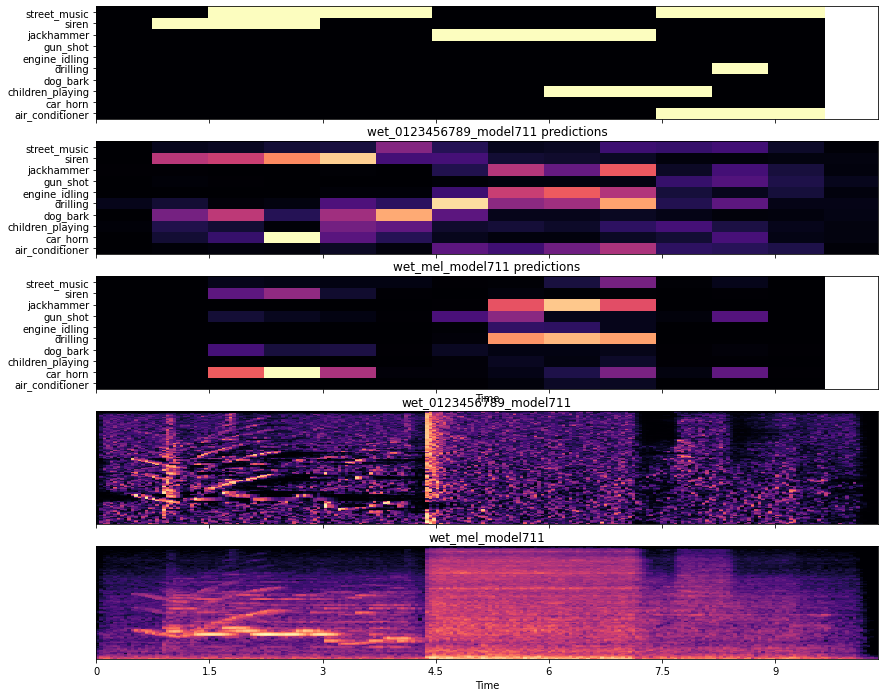

In [118]:
fig, ax = plt.subplots(nrows=5, figsize=(14,12), sharex=True)

#plot tags
cf_tags = specshow(true_tags.T, ax=ax[0], x_axis='time', sr= 22050, hop_length=1024*16)
ax[0].label_outer()
ax[0].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[0].set_yticklabels(labels=URBANSED_CLASSES)


#plot predictions
cf_pcen_pred = specshow(pcen_preds.T, ax=ax[1], x_axis='time', sr= 22050, hop_length=1024*16)#ax[1].pcolormesh(, vmin=0, vmax=1)
ax[1].label_outer()
ax[1].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[1].set_yticklabels(labels=URBANSED_CLASSES)
ax[1].set_title(pcen_model_name + " predictions")

cf_mel_pred = specshow(mel_preds.T, ax=ax[2], x_axis='time', sr= 22050, hop_length=1024*16)#ax[2].pcolormesh(mel_preds.T, vmin=0, vmax=1)
ax[1].label_outer()
ax[2].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[2].set_yticklabels(labels=URBANSED_CLASSES)
ax[2].set_title(mel_model_name + " predictions")


#plot audio
cf_pcen = specshow(pcen_data, ax=ax[3], x_axis='time', sr= 22050, hop_length=1024)#ax[3].pcolormesh(pcen_data, vmin=0, vmax=1)
ax[3].label_outer()
ax[3].set_yticks([])
ax[3].set_title(pcen_model_name)
cf_mel = specshow(mel_data, ax=ax[4], x_axis='time', sr= 22050, hop_length=1024)
ax[4].label_outer()
ax[4].set_yticks([])
ax[4].set_title(mel_model_name)

In [119]:
URBANSED_CLASSES = ['air_conditioner',
                    'car_horn',
                    'children_playing',
                    'dog_bark',
                    'drilling',
                    'engine_idling',
                    'gun_shot',
                    'jackhammer',
                    'siren',
                    'street_music']


def convert_ts_to_dict(predictions, labels, fname, threshold=None, real_length = 10.):
    predictions = predictions.T
    out_dicts = []
    sr = real_length/predictions.shape[1]
    
    for i, label in enumerate(labels):
        if threshold is not None:
            high_low_array = (predictions[i]>threshold).astype(int)
        else:
            high_low_array = predictions[i]
        
        label_data = np.concatenate((np.zeros(1), high_low_array.flatten(), np.zeros(1)))
        onsets = np.argwhere(np.diff(label_data)==1) -1
        offsets = np.argwhere(np.diff(label_data)==-1) -1

        
        for i in range(len(onsets)):
            new_dict = {}
            new_dict['event_label']=label
            new_dict['event_onset']=onsets[i][0]*sr
            new_dict['event_offset']=offsets[i][0]*sr
            new_dict['file']=fname
            new_dict['scene_label']= 'UrbanSED'
            out_dicts.append(new_dict)
    return out_dicts

In [120]:
true_tags_dict = convert_ts_to_dict(true_tags, URBANSED_CLASSES, 'file')

In [121]:
true_tags_dict

[{'event_label': 'air_conditioner',
  'event_onset': 6.923076923076923,
  'event_offset': 9.230769230769232,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'children_playing',
  'event_onset': 5.384615384615385,
  'event_offset': 7.6923076923076925,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'drilling',
  'event_onset': 7.6923076923076925,
  'event_offset': 8.461538461538462,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'jackhammer',
  'event_onset': 3.8461538461538463,
  'event_offset': 6.923076923076923,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'siren',
  'event_onset': 0.0,
  'event_offset': 2.307692307692308,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'street_music',
  'event_onset': 0.7692307692307693,
  'event_offset': 3.8461538461538463,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'street_music',
  'event_onset': 6.923076923076923,
  'event_offset': 9.23

In [122]:
pcen_preds_dict = convert_ts_to_dict(pcen_preds, URBANSED_CLASSES, 'file', threshold=0.5)

In [123]:
pcen_preds_dict

[{'event_label': 'car_horn',
  'event_onset': 1.4285714285714286,
  'event_offset': 2.142857142857143,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'dog_bark',
  'event_onset': 2.857142857142857,
  'event_offset': 3.5714285714285716,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'drilling',
  'event_onset': 3.5714285714285716,
  'event_offset': 4.285714285714286,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'drilling',
  'event_onset': 5.714285714285714,
  'event_offset': 6.428571428571429,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'engine_idling',
  'event_onset': 5.0,
  'event_offset': 5.714285714285714,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'jackhammer',
  'event_onset': 5.714285714285714,
  'event_offset': 6.428571428571429,
  'file': 'file',
  'scene_label': 'UrbanSED'},
 {'event_label': 'siren',
  'event_onset': 1.4285714285714286,
  'event_offset': 2.857142857142857,
  'f

In [124]:
import jams
test_jams = jams.load(test_annotations)

In [125]:
jams_df = test_jams.annotations[0].to_dataframe()

In [126]:
jams_df['value'] = jams_df['value'].apply(lambda x: x['label'])

In [127]:
jams_df

,time,duration,value,confidence
0,0.067507,10.000000,noise,1.0
1,0.494539,1.872740,siren,1.0
2,0.927469,3.217129,street_music,1.0
3,4.404853,2.743097,jackhammer,1.0
4,5.260924,2.511364,children_playing,1.0
5,6.886533,2.787893,air_conditioner,1.0
6,7.234905,2.036934,street_music,1.0
7,7.709609,0.665056,drilling,1.0
